In [1]:
#convert

# babilim.data.datasets.coco

> An implementation to load the coco dataset into babilim.

In [2]:
#hide
import os
os.environ["DATA_PATH"] = "E:\\DeepLearning\\datasets"

In [3]:
#export
import os
import json
import numpy as np
import cv2
from collections import namedtuple
from imageio import imread
from babilim.core.config import Config
from babilim.data.dataset import Dataset
from babilim import SPLIT_TRAIN, SPLIT_DEV, SPLIT_TEST

In [4]:
#export
CocoInput = namedtuple("CocoInput", ["image"])
CocoOutput = namedtuple("CocoOutput", ["instances"])

In [5]:
#export
class CocoDataset(Dataset):
    def __init__(self, config, dataset_folder, phase):
        super().__init__(config)
        self.dataset_folder = dataset_folder
        self.phase = phase
        self.images = {}
        self.instance_annotations = {}
        self.skeleton_annotations = {}
        if phase == SPLIT_TRAIN:
            self._read_anno_file("train2014")
            self._read_anno_file("train2017")
        if phase == SPLIT_DEV:
            self._read_anno_file("val2014")
            self._read_anno_file("val2017")
        self.sample_tokens = list(self.images.keys())

    def _read_anno_file(self, split):
        annofile = os.path.join(self.dataset_folder, "annotations", "instances_{}.json".format(split))
        with open(annofile, "r") as f:
            annos = json.load(f)
        for x in annos["images"]:
            self.images[x["id"]] = os.path.join(split, "{}".format(x["file_name"]))
        for x in annos["annotations"]:
            self.instance_annotations[x["id"]] = x
        annofile = os.path.join(self.dataset_folder, "annotations", "person_keypoints_{}.json".format(split))
        with open(annofile, "r") as f:
            annos = json.load(f)
        for x in annos["annotations"]:
            self.skeleton_annotations[x["id"]] = x

    def __len__(self) -> int:
        return len(self.sample_tokens)

    def getitem(self, idx: int):
        """
        Implements the getitem required by the babilim.data.Dataset.
        
        This function gets called when you do `feat, label = dataset[idx]`.
        
        :param idx: The index in the dataset.
        :return: A tuple (feat, label). The type of feat is `self.InputType` and the type of label is `self.OutputType`.
        """
        sample_token = self.sample_tokens[idx]
        return self.get_by_sample_token(sample_token)
        
    def get_by_sample_token(self, sample_token: str):
        """
        Get a datapoint 
        """
        return CocoInput(self._get_image(sample_token)), CocoOutput(self._get_instances(sample_token))

    def _get_image(self, sample_token: str):
        filename = os.path.join(self.dataset_folder, "images", self.images[sample_token])
        return cv2.imread(filename)[:, :, ::-1]

    def _get_instances(self, sample_token: str):
        return self.instance_annotations[sample_token]

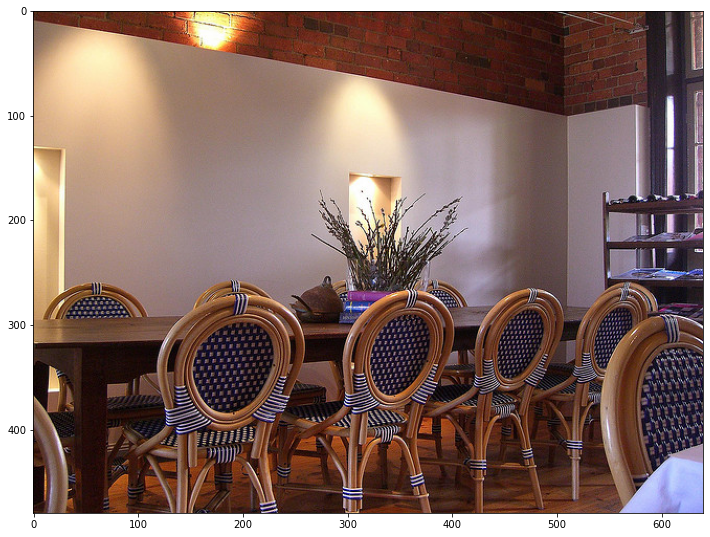

In [6]:
import matplotlib.pyplot as plt

class CocoConfig(Config):
    def __init__(self):
        super().__init__()
        self.train_batch_size = 1

config = CocoConfig()
dataset = CocoDataset(config, os.path.join(os.environ["DATA_PATH"], "COCO"), SPLIT_TRAIN)
dataset_input, dataset_output = dataset[0]

plt.figure(figsize=(12,12))
plt.imshow(dataset_input.image)
plt.show()